## X-ray Pulse Pattern

The AGIPD detector stores images with a repetition rate up to 4.5MHz corresponding to a spacing of 220ns between acquisitions. AGIPD saves images in so-called storage cells. The EuXFEL data piplein processes the raw data and stores processed data. Depending on the configuration of the pipeline only certain storage cells can be processed and stored. 

Even if every storage cell is processed, the X-ray pulse pattern can be configured such that the pulses arrive not with 4.5Mhz but with 2.25MHz or slower, i.e., every second, third, etc. pulse is skipped. Consequently, not every storage cell should be considered by the analysis. MIDtools provides the `cell_step` argument which tells the algorithms to skip those empty storage cells in the processsed data. 

Additionally, the AGIPD acquisition timing can be shifted relatively to the X-ray pulse timing such that the first X-ray pulse is stored in an arbitrary storage cell. To skip all empty storage cells and start the data analysis with the first storage cell that actually measured X-rays, MIDtools provides the `first_cell` argument. 

Importantly, `cell_step` and `first_cell` work with the processed data so changing the configuration of the XFEL data processing pipeline might affect those values. Here are some examples:

1. XFEL deliveres 200 X-ray pulses with 2.25Mhz (440ns delay). The agipd timing is configured such that the first X-ray pulse is measured by storage cell 130. The data pipeline is configured such that all AGIPD storage cells are processed. In this case you want to set `first_cell=130` and `cell_step=1`.
    
2. XFEL deliveres 200 X-ray pulses with 2.25Mhz (440ns delay). The agipd timing is configured such that the first X-ray pulse is measured by storage cell 130. The data pipeline is configured such that all AGIPD storage cells are processed. In this case you want to set `first_cell=130` and `cell_step=1`.

3. XFEL deliveres 200 X-ray pulses with 1.125Mhz (880ns delay). The agipd timing is configured such that the first X-ray pulse is measured by storage cell 130. The data pipeline is configured such that all AGIPD storage cells are processed. In this case you want to set `first_cell=130` and `cell_step=2` (every second frame in the processed data will be empty).

4. XFEL deliveres 200 X-ray pulses with 1.125Mhz (880ns delay). The agipd timing is configured such that the first X-ray pulse is measured by storage cell 130. The data pipeline is configured such that every second AGIPD storage cell is processed to match the 1.125MHz. In this case you want to set `first_cell=130` and `cell_step=1` (every second storage cell measured X-rays, but the data processing pipeline excluded the empty cells).

Usually, the pulse pattern should be documented in the logbook. In case this information is missing, this notebook shows how to obtain `first_cell`, `cell_step`, and `number_of_pulses` from the processed data.

**Imports**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from getpass import getuser

**Import midtools methods**

In [ ]:
from extra_data import open_run
from midtools.helpers import get_pulse_intensity, get_agipd_pulse_pattern, start_slurm_cluster

Start a small SLURMCluster with 2 nodes.

In [ ]:
cluster, client = start_slurm_cluster(2, partition='exfel')

Check that 2 dask workers are running. The `ST` (status) column should display `R` for a running worker. `PD` means the allocation is pending.

In [ ]:
!squeue -u {getuser()}

Use the next cell to kill stale dask workders if necessary. **NOTE:** This will also kill dask workers of other SLURMClusters you are running.

In [59]:
# !scancel -n dask-worker

## Measurements

Choose two Ig-PEG measurements with different pulse frequencies.

In [61]:
measurements = []

# Ig-PEG 2.2 Mhz
run_number = 300  
proposal = 2718
measurements.append((proposal, run_number))


# Ig-PEG 1.1 MHz
run_number = 340  
proposal = 2718
measurements.append((proposal, run_number))

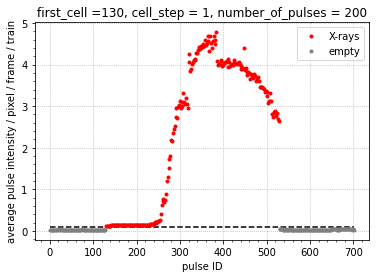

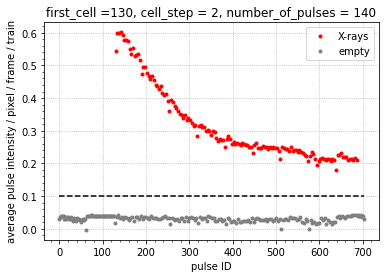

In [63]:
# iterate over measurements
for proposal, run_number in measurements:

    # create the main data access object with open_run
    run = open_run(proposal=proposal, run=run_number, data='proc')

    # create DASK graph to load AGIPD images and calculate the average intensity per pixel
    pulse_intensity = get_pulse_intensity(run, number_of_trains=100)

    # actually run the computation and load the data
    pulse_intensity = pulse_intensity.compute()

    # use the pulse intensity to get the pulse pattern right
    first_cell, cell_step, number_of_pulses = get_agipd_pulse_pattern(pulse_intensity, threshold=.1, plot=True)